# **Data Preparation**

In [1]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import LabelBinarizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/data'

filenames = glob.glob(path + "/*set*.csv")

load = []
for filename in filenames:
    load.append(pd.read_csv(filename))

### Basic Preprocessing

In [4]:
data = pd.concat([doc for doc in load]) # combine 3 datasets
data = data.drop_duplicates(subset=["tweet"]) # remove any duplicates
data = data.sample(frac=1).reset_index(drop=True) # randomize row order
data.drop(["id"], axis=1, inplace=True) # drop un-needed columns
data.shape

(10699, 2)

In [5]:
data.head()

,tweet,label
0,Fit people are immune to novel coronavirus,fake
1,Yesterday our laboratories processed 4279 test...,real
2,RT @MoHFW_INDIA: #IndiaFightsCorona Around 60%...,real
3,I want to thank the #UnitedKingdom🇬🇧 #Egypt🇪🇬 ...,real
4,Our total number of confirmed cases is 1205 wh...,real


### Cleaning


In [6]:
import re

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

In [7]:
from gensim.parsing.preprocessing import STOPWORDS

def remove_stopwords(sample):
  return " ".join([i for i in sample.split() if i not in STOPWORDS])

In [8]:
data.tweet = data.tweet.apply(remove_URL).apply(remove_stopwords)

In [9]:
data.head()

,tweet,label
0,Fit people immune novel coronavirus,fake
1,Yesterday laboratories processed 4279 tests. T...,real
2,RT @MoHFW_INDIA: #IndiaFightsCorona Around 60%...,real
3,I want thank #UnitedKingdom🇬🇧 #Egypt🇪🇬 #Indone...,real
4,Our total number confirmed cases 1205 number r...,real


### Trimming for Padding

In [10]:
tweet_lengths = []

for tweet in data.tweet:
    tweet_lengths.append(len(tweet.split()))

In [11]:
np.quantile(np.array(tweet_lengths), [i/100 for i in range(101)])

array([  2.,   4.,   5.,   5.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,
         7.,   8.,   8.,   8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,
        10.,  10.,  10.,  10.,  10.,  11.,  11.,  11.,  11.,  11.,  12.,
        12.,  12.,  12.,  12.,  13.,  13.,  13.,  13.,  14.,  14.,  14.,
        14.,  15.,  15.,  15.,  15.,  16.,  16.,  16.,  16.,  17.,  17.,
        17.,  17.,  18.,  18.,  18.,  19.,  19.,  19.,  19.,  20.,  20.,
        20.,  21.,  21.,  21.,  22.,  22.,  22.,  22.,  23.,  23.,  23.,
        24.,  24.,  24.,  24.,  25.,  25.,  25.,  26.,  26.,  26.,  27.,
        27.,  27.,  28.,  28.,  28.,  29.,  29.,  30.,  31.,  32.,  33.,
        37., 929.])

In [12]:
# remove tweets with length > 54 words (keep 99% of data)
max_len = 54
data = data[data["tweet"].apply(lambda x: len(x.split()) <= max_len)]

In [13]:
data.value_counts(["label"])

label
real     5597
fake     5083
dtype: int64

### Train-Validation-Test split

In [14]:
target = np.where(data.label == 'fake', 1, 0)

In [15]:
# train-test split: 90/10
n = data.shape[0]
split = int(n*0.9)

train_X = np.array(data[:split].tweet)
train_Y = target[:split]

test_X = np.array(data[split+1:].tweet)
test_Y = target[split+1:]

In [16]:
# verifying shapes
all([train_X.shape[0] == train_Y.shape[0],
     test_X.shape[0] == test_Y.shape[0]])

True

# **Load GloVe Embeddings**

### Define function to load glove file

In [17]:
import io

def read_glove_vecs(glove_file, dim):
    with io.open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            if len(line) != dim + 1:
                continue
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

### Load pre-trained 50-dimensional GloVe embeddings

In [18]:
%%time
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(path + '/glove.twitter.27B.50d.txt', dim=50)

CPU times: user 21.7 s, sys: 1.41 s, total: 23.1 s
Wall time: 23.6 s


In [19]:
word_to_index['hello']

254760

In [20]:
index_to_word[200000]

'falln'

In [21]:
word_to_vec_map['good']

array([ 0.6608  , -0.10159 ,  0.026775, -0.088053,  0.15578 ,  0.87288 ,
        1.29    ,  0.28934 , -0.59205 ,  0.26779 , -0.76604 ,  0.27955 ,
       -5.1483  , -0.056899, -0.050798, -0.083225,  0.48048 , -0.35409 ,
       -1.0566  ,  0.065436, -0.46674 ,  0.13847 , -0.22022 ,  0.61591 ,
        0.18462 ,  0.77965 ,  0.29022 , -0.24679 ,  0.95335 , -0.35699 ,
       -0.24246 ,  0.35939 , -0.16369 ,  0.30926 ,  0.32784 ,  0.66924 ,
       -0.028869,  0.13981 ,  0.12371 ,  0.96181 , -1.4018  , -0.19285 ,
        0.79053 ,  0.36647 ,  0.32751 ,  0.29666 , -0.039173, -0.14523 ,
       -0.19663 ,  0.026827])

# **Word Processing Functions**

In [22]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, InputLayer, Dropout, LSTM, Activation, 
                                     Conv1D, MaxPool1D, Bidirectional)
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [23]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        sentence_words = X[i].lower().split()
        j = 0

        for w in sentence_words:
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
                j += 1
    
    return X_indices

In [24]:
# trying out the function
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[217642. 346223.      0.      0.      0.]
 [339236. 482461.  56031.      0.      0.]
 [211511. 283379. 509169. 211803. 668737.]]


In [25]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)

    # Step 4
    # Build the embedding layer
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [26]:
# trying out function
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim", embedding_layer.output_dim)

weights[0][1][1] = -0.71792
Input_dim 1193514
Output_dim 50


# **Hybrid Architecture**

In [27]:
from kerastuner import HyperModel
from tensorflow import keras

In [28]:
class LSTM_HyperModel(HyperModel):
    def __init__(self, input_shape, word_to_vec_map, word_to_index):
        self.input_shape = input_shape
        self.word_to_vec_map = word_to_vec_map
        self.word_to_index = word_to_index
        self.embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    def build(self, hp):
        model = keras.Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        model.add(self.embedding_layer)
        model.add(
            Conv1D(filters=32, 
                   kernel_size=3, 
                   activation=hp.Choice('dense_activation',
                                        values=['relu', 'tanh', 'sigmoid'],
                                        default='relu'
                                        )
                   )
          )
        model.add(MaxPool1D(pool_size=2))
        model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
        model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
        model.add(
            Dropout(
                rate=hp.Float('dropout_1', min_value=0.0,
                              max_value=0.5, default=0.25, step=0.05)
                )
            )
        model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
        model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
        model.add(
            Dropout(
                rate=hp.Float('dropout_2', min_value=0.0,
                              max_value=0.5, default=0.25, step=0.05)
                )
            )
        model.add(
            Dense(
                units=hp.Int('units_1', min_value=32, max_value=512, 
                             step=32, default=128)
                )
            )
        model.add(
            Dense(
                units=hp.Int('units_2', min_value=32, max_value=512, 
                             step=32, default=128)
                )
            )
        model.add(Dense(units=1))
        model.add(Activation(activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2,
                         sampling='LOG', default=1e-3)
                ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

hypermodel = LSTM_HyperModel((max_len,), word_to_vec_map, word_to_index)

# Optimization Hyperparameter Tuning

### Tuner Setup

In [29]:
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

In [34]:
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=20,
    executions_per_trial=1,
    directory='random_search',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Model Tuning

In [32]:
train_X_indices = sentences_to_indices(train_X, word_to_index, max_len)

In [36]:
N_EPOCH_SEARCH = 10
tuner.search(train_X_indices, train_Y, epochs=N_EPOCH_SEARCH, 
             validation_split=0.1, callbacks=[stop_early])

Trial 20 Complete [00h 04m 56s]
val_accuracy: 0.897089421749115

Best val_accuracy So Far: 0.9126819372177124
Total elapsed time: 01h 37m 50s
INFO:tensorflow:Oracle triggered exit


In [38]:
tuner.results_summary()

Results summary
Results in random_search/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.25
dropout_2: 0.1
units_1: 512
units_2: 320
learning_rate: 0.006718710759425462
Score: 0.9126819372177124
Trial summary
Hyperparameters:
dense_activation: sigmoid
dropout_1: 0.45
dropout_2: 0.1
units_1: 480
units_2: 480
learning_rate: 0.0026588018706229753
Score: 0.9043658971786499
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.5
dropout_2: 0.1
units_1: 160
units_2: 320
learning_rate: 0.003860825451272157
Score: 0.9022868871688843
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.15000000000000002
dropout_2: 0.25
units_1: 96
units_2: 256
learning_rate: 0.0029044390072926946
Score: 0.9022868871688843
Trial summary
Hyperparameters:
dense_activation: relu
dropout_1: 0.2
dropout_2: 0.45
units_1: 288
units_2: 384
learning_rate: 0.0005510469719519641
Score: 0.897

### Tune Optimal Epochs


In [39]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
best_model = tuner.hypermodel.build(best_hyppar)
history = best_model.fit(train_X_indices, train_Y, epochs=50, validation_split=0.1)

Epoch 1/50
271/271 [==============================] - 41s 104ms/step - loss: 0.4449 - accuracy: 0.8061 - val_loss: 0.3050 - val_accuracy: 0.8742
Epoch 2/50
271/271 [==============================] - 25s 91ms/step - loss: 0.3221 - accuracy: 0.8705 - val_loss: 0.2685 - val_accuracy: 0.8919
Epoch 3/50
271/271 [==============================] - 25s 92ms/step - loss: 0.2613 - accuracy: 0.8948 - val_loss: 0.2591 - val_accuracy: 0.9002
Epoch 4/50
271/271 [==============================] - 24s 89ms/step - loss: 0.2231 - accuracy: 0.9113 - val_loss: 0.2594 - val_accuracy: 0.9002
Epoch 5/50
271/271 [==============================] - 24s 90ms/step - loss: 0.1962 - accuracy: 0.9227 - val_loss: 0.2706 - val_accuracy: 0.8857
Epoch 6/50
271/271 [==============================] - 24s 90ms/step - loss: 0.1636 - accuracy: 0.9378 - val_loss: 0.3724 - val_accuracy: 0.8960
Epoch 7/50
271/271 [==============================] - 24s 89ms/step - loss: 0.1504 - accuracy: 0.9423 - val_loss: 0.2903 - val_accuracy

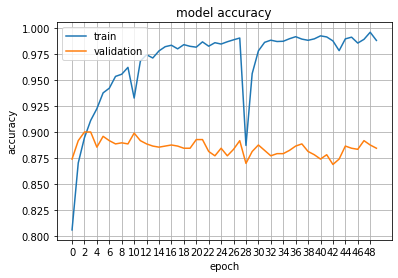

<Figure size 432x288 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xticks(range(0,50, 2))
plt.grid()
plt.show()
plt.savefig(path + "/accuracy.png")

In [42]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 3


### Train Best Model




In [44]:
final_model = tuner.hypermodel.build(best_hyppar)
final_model.fit(train_X_indices, train_Y, epochs=3, validation_split=0.1)

Epoch 1/3
271/271 [==============================] - 38s 94ms/step - loss: 0.4664 - accuracy: 0.7860 - val_loss: 0.3170 - val_accuracy: 0.8732
Epoch 2/3
271/271 [==============================] - 22s 81ms/step - loss: 0.3299 - accuracy: 0.8637 - val_loss: 0.3070 - val_accuracy: 0.8794
Epoch 3/3
271/271 [==============================] - 22s 82ms/step - loss: 0.2696 - accuracy: 0.8935 - val_loss: 0.2679 - val_accuracy: 0.9012


In [45]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 54, 50)            59675700  
_________________________________________________________________
conv1d (Conv1D)              (None, 52, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 64)            24832     
_________________________________________________________________
dropout (Dropout)            (None, 26, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 26, 64)            2

In [51]:
test_X_indices = sentences_to_indices(test_X, word_to_index, max_len)
loss, accuracy = final_model.evaluate(test_X_indices, test_Y)

34/34 [==============================] - 1s 21ms/step - loss: 0.3005 - accuracy: 0.8688


In [52]:
pred = final_model.predict(test_X_indices)
pred = np.where(pred > 0.5, 1, 0)

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_Y, pred)
cm

array([[474,  80],
       [ 60, 453]])

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_Y, pred)

0.8693183017712753